# Meta-Learning Methods: Learning to Learn

W poprzednich sekcjach poznaliśmy metody metric-based (Prototypical Networks, Matching Networks), które uczą się **dobrej przestrzeni embeddingów** i klasyfikują nowe przykłady przez porównywanie odległości.

W tej sekcji poznamy podejście **meta-learning**, które idzie o krok dalej: zamiast uczyć się tylko reprezentacji, uczymy się **jak szybko adaptować model do nowego zadania**.

---

## Czym jest Meta-Learning?

**Meta-learning** (uczenie się uczenia) to podejście, w którym model uczy się **algorytmu uczenia** lub **dobrej inicjalizacji wag**, tak aby po zobaczeniu kilku przykładów z nowego zadania mógł się szybko zaadaptować.

**Kluczowa różnica:**
- **Metric-based FSL:** Uczymy embeddingi → porównujemy odległości → brak zmiany wag podczas inference
- **Meta-learning:** Uczymy inicjalizację → kilka kroków gradient descent → wagi się zmieniają dla każdego nowego zadania

---

## Podstawowe pojęcia

### Task / Episode
- **Task (zadanie):** Jeden problem few-shot, np. klasyfikacja 3 klas po 5 przykładów każda
- **Episode:** Jedna iteracja treningowa, w której losujemy nowy task

### Inner Loop (pętla wewnętrzna)
- Adaptacja modelu do **konkretnego taska**
- Kilka kroków gradient descent na support set
- Wagi modelu są **tymczasowo** modyfikowane

### Outer Loop (pętla zewnętrzna)
- Aktualizacja **meta-parametrów** (inicjalizacji)
- Optymalizujemy tak, aby po inner loop model dobrze działał na query set
- To jest "uczenie się jak się uczyć"

---

## Intuicja

Wyobraź sobie, że szukasz **punktu startowego w przestrzeni wag**, z którego:
- Po kilku krokach w dowolnym kierunku (różne taski)
- Zawsze dojdziesz do dobrego rozwiązania

Meta-learning znajduje taki "uniwersalny" punkt startowy.

## Problem, który rozwiązuje Meta-Learning

### Kiedy metric-based nie wystarcza?

Metody oparte na metrykach (ProtoNet, Matching Networks) działają świetnie, gdy:
- Pretrenowany encoder tworzy dobre embeddingi
- Klasy są dobrze separowalne w przestrzeni embeddingów

**Ale co jeśli:**
- Nowe zadanie wymaga innej reprezentacji niż ta nauczona podczas pretrainingu?
- Klasy są bardzo podobne i wymagają subtelnych rozróżnień?
- Mamy do czynienia z zadaniem innym niż klasyfikacja (np. regresja)?

### Kiedy potrzebna jest adaptacja wag?

- Gdy proste porównywanie odległości nie wystarcza
- Gdy chcemy, aby model **naprawdę się uczył** z nowych przykładów
- Gdy zadania są bardzo różnorodne

**Meta-learning pozwala na prawdziwą adaptację** – model zmienia swoje wagi w odpowiedzi na nowe dane.

## MAML – Model-Agnostic Meta-Learning

**MAML** (Finn et al., 2017) to jedna z najbardziej wpływowych metod meta-learningu.

### Główna idea

1. **Znajdź dobrą inicjalizację wag** $\theta$
2. Dla każdego nowego taska: wykonaj kilka kroków gradient descent
3. Po tych krokach model powinien dobrze działać na query set

### Dlaczego "Model-Agnostic"?

MAML działa z **dowolną architekturą** i **dowolną funkcją straty** – wystarczy, że model jest różniczkowalny.

---

### Pseudokod MAML

```
Inicjalizuj meta-parametry θ

for each meta-iteration:
    Wylosuj batch tasków T₁, T₂, ..., Tₙ
    
    for each task Tᵢ:
        # INNER LOOP (adaptacja)
        Pobierz support set Sᵢ i query set Qᵢ
        θ'ᵢ = θ - α · ∇θ L(θ, Sᵢ)     # jeden lub kilka kroków GD
        
        # Oblicz loss na query set z zaadaptowanymi wagami
        Lᵢ = L(θ'ᵢ, Qᵢ)
    
    # OUTER LOOP (meta-update)
    θ = θ - β · ∇θ Σᵢ Lᵢ              # gradient przez gradienty!
```

**Kluczowe:**
- $\alpha$ – learning rate dla inner loop (adaptacji)
- $\beta$ – learning rate dla outer loop (meta-update)
- Gradient w outer loop przechodzi **przez** operację inner loop

In [ ]:
# MAML - Minimalny przykład na danych syntetycznych 2D
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

torch.manual_seed(42)

# Prosty model klasyfikacji binarnej
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def generate_task(n_support=5, n_query=10):
    """
    Generuje jeden task: klasyfikacja 2 gaussów.
    Każdy task ma losowe centrum klas - GWARANTUJEMY SEPARACJĘ.
    """
    # Losowy kierunek separacji
    angle = torch.rand(1) * 2 * 3.14159
    direction = torch.tensor([torch.cos(angle), torch.sin(angle)]).squeeze()
    
    # Centra oddalone od siebie
    offset = torch.randn(2) * 2  # losowe przesunięcie całego taska
    center0 = offset - direction * 2
    center1 = offset + direction * 2
    
    # Support set
    support_x0 = torch.randn(n_support, 2) * 0.5 + center0
    support_x1 = torch.randn(n_support, 2) * 0.5 + center1
    support_x = torch.cat([support_x0, support_x1], dim=0)
    support_y = torch.cat([torch.zeros(n_support), torch.ones(n_support)]).long()
    
    # Query set
    query_x0 = torch.randn(n_query, 2) * 0.5 + center0
    query_x1 = torch.randn(n_query, 2) * 0.5 + center1
    query_x = torch.cat([query_x0, query_x1], dim=0)
    query_y = torch.cat([torch.zeros(n_query), torch.ones(n_query)]).long()
    
    # Shuffle
    perm_s = torch.randperm(len(support_y))
    perm_q = torch.randperm(len(query_y))
    
    return support_x[perm_s], support_y[perm_s], query_x[perm_q], query_y[perm_q]

In [ ]:
def functional_forward(x, params):
    """
    Forward pass z podanymi wagami (functional style).
    """
    x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
    return x

def inner_loop_update(params, support_x, support_y, inner_lr, inner_steps):
    """
    Inner loop: adaptacja modelu na support set.
    Zwraca zaadaptowane wagi (jako słownik).
    """
    adapted_params = {k: v.clone() for k, v in params.items()}
    
    for _ in range(inner_steps):
        logits = functional_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        
        grads = torch.autograd.grad(loss, adapted_params.values(), create_graph=True)
        
        adapted_params = {
            k: v - inner_lr * g 
            for (k, v), g in zip(adapted_params.items(), grads)
        }
    
    return adapted_params

In [ ]:
# Trening MAML
model = SimpleClassifier()
meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

inner_lr = 0.5       # wyższy learning rate dla inner loop
inner_steps = 5      # liczba kroków adaptacji
n_tasks = 4          # liczba tasków w każdej meta-iteracji
n_meta_iterations = 1000

losses = []

for meta_iter in range(n_meta_iterations):
    meta_loss = 0.0
    
    # Pobierz aktualne parametry modelu
    params = {k: v for k, v in model.named_parameters()}
    
    for _ in range(n_tasks):
        # Generuj nowy task
        support_x, support_y, query_x, query_y = generate_task()
        
        # Inner loop: adaptacja na support set
        adapted_params = inner_loop_update(params, support_x, support_y, inner_lr, inner_steps)
        
        # Oblicz loss na query set z zaadaptowanymi wagami
        query_logits = functional_forward(query_x, adapted_params)
        task_loss = F.cross_entropy(query_logits, query_y)
        
        meta_loss += task_loss
    
    meta_loss = meta_loss / n_tasks
    
    # Outer loop: meta-update
    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()
    
    losses.append(meta_loss.item())
    
    if meta_iter % 200 == 0:
        print(f"Meta-iteration {meta_iter}, Meta-loss: {meta_loss.item():.4f}")

print("Trening zakończony!")

Meta-iteration 0, Meta-loss: 0.0502
Meta-iteration 200, Meta-loss: 0.2332
Meta-iteration 400, Meta-loss: 0.0804
Meta-iteration 600, Meta-loss: 0.1864
Meta-iteration 800, Meta-loss: 0.0827
Trening zakończony!


In [ ]:
# Ewaluacja: porównanie przed i po adaptacji
def evaluate_model(model, support_x, support_y, query_x, query_y, inner_lr, inner_steps):
    """
    Zwraca accuracy przed i po adaptacji.
    """
    params = {k: v.clone() for k, v in model.named_parameters()}
    
    # Przed adaptacją
    with torch.no_grad():
        logits_before = functional_forward(query_x, params)
        preds_before = logits_before.argmax(dim=1)
        acc_before = (preds_before == query_y).float().mean().item()
    
    # Po adaptacji (bez create_graph dla ewaluacji)
    adapted_params = {k: v.clone() for k, v in params.items()}
    for _ in range(inner_steps):
        logits = functional_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        grads = torch.autograd.grad(loss, adapted_params.values())
        adapted_params = {
            k: v - inner_lr * g 
            for (k, v), g in zip(adapted_params.items(), grads)
        }
    
    with torch.no_grad():
        logits_after = functional_forward(query_x, adapted_params)
        preds_after = logits_after.argmax(dim=1)
        acc_after = (preds_after == query_y).float().mean().item()
    
    return acc_before, acc_after

# Test na kilku nowych taskach
print("Ewaluacja na nowych taskach:")
print("-" * 40)

accs_before = []
accs_after = []

for i in range(10):
    support_x, support_y, query_x, query_y = generate_task()
    acc_before, acc_after = evaluate_model(
        model, support_x, support_y, query_x, query_y, inner_lr, inner_steps
    )
    accs_before.append(acc_before)
    accs_after.append(acc_after)
    print(f"Task {i+1}: Before={acc_before:.2f}, After={acc_after:.2f}")

print("-" * 40)
print(f"Średnia przed adaptacją: {sum(accs_before)/len(accs_before):.2f}")
print(f"Średnia po adaptacji:    {sum(accs_after)/len(accs_after):.2f}")

Ewaluacja na nowych taskach:
----------------------------------------
Task 1: Before=1.00, After=0.50
Task 2: Before=0.95, After=0.75
Task 3: Before=0.15, After=1.00
Task 4: Before=0.00, After=1.00
Task 5: Before=0.35, After=1.00
Task 6: Before=0.00, After=1.00
Task 7: Before=0.00, After=1.00
Task 8: Before=0.00, After=1.00
Task 9: Before=0.95, After=1.00
Task 10: Before=1.00, After=1.00
----------------------------------------
Średnia przed adaptacją: 0.44
Średnia po adaptacji:    0.93


## Co tak naprawdę się tutaj uczy?

### Interpretacja geometryczna

MAML szuka takiego **punktu startowego w przestrzeni wag** $\theta$, że:

1. Dla **każdego możliwego taska** $T_i$
2. Po wykonaniu **kilku kroków gradient descent** w kierunku minimalizacji straty na $T_i$
3. Otrzymujemy **dobre rozwiązanie** dla tego taska

**Wizualnie:**
- Wyobraź sobie przestrzeń wag jako wielowymiarową powierzchnię
- Każdy task to "dolina" w tej powierzchni (lokalne minimum)
- MAML szuka punktu, z którego **łatwo zjeżdżamy** do każdej doliny

```
        θ* (MAML init)
           /  |  \
          /   |   \
         ↓    ↓    ↓
       θ₁'  θ₂'  θ₃'   (po adaptacji na różne taski)
```

### Dlaczego to działa?

- Zwykły trening daje dobre rozwiązanie dla **jednego zadania**
- MAML daje **dobre punkty startowe** dla **wielu zadań**
- Po kilku krokach GD jesteśmy blisko optymalnego rozwiązania dla nowego taska

### Gradient przez gradient

Kluczowa innowacja MAML: gradient w outer loop przechodzi **przez** operację inner loop.

To znaczy, że optymalizujemy:
$$\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\theta - \alpha \nabla_\theta \mathcal{L}(\theta, S), Q)$$

Dzięki temu model uczy się, jak **zmieniać swoje wagi** w odpowiedzi na nowe dane.

## Inne metody Meta-Learning

### FOMAML (First-Order MAML)

- Uproszczona wersja MAML
- Ignoruje drugie pochodne (gradient przez gradient)
- Szybsza obliczeniowo, często działa prawie tak dobrze

```python
# MAML: gradient przez adaptację
grads = torch.autograd.grad(..., create_graph=True)

# FOMAML: ignorujemy drugą pochodną
grads = torch.autograd.grad(..., create_graph=False)
```

---

### Reptile

- Jeszcze prostsza alternatywa
- Nie wymaga gradientów przez gradient
- Algorytm:
  1. Wylosuj task
  2. Zrób kilka kroków SGD na tym tasku: $\theta \to \tilde{\theta}$
  3. Meta-update: $\theta \leftarrow \theta + \epsilon(\tilde{\theta} - \theta)$

**Intuicja:** Przesuwaj inicjalizację w kierunku rozwiązań.

---

### Meta-SGD

- Rozszerzenie MAML
- Oprócz inicjalizacji $\theta$, uczy się też **learning rate** dla każdego parametru
- Pozwala na bardziej precyzyjną adaptację

---

### LSTM Meta-Learner

- Zamiast gradient descent w inner loop
- Używa **sieci rekurencyjnej (LSTM)** do przewidywania aktualizacji wag
- Uczy się algorytmu uczenia jako funkcji

## FOMAML: First-Order MAML - Szczegóły

### Dlaczego FOMAML?

Pełny MAML wymaga obliczania **drugich pochodnych** (Hessian), co jest:
- Kosztowne obliczeniowo
- Wymaga dużo pamięci (przechowywanie grafu obliczeniowego)
- Może być niestabilne numerycznie

**FOMAML** (First-Order MAML) to aproksymacja, która **ignoruje drugie pochodne**.

### Matematycznie

W pełnym MAML optymalizujemy:
$$\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\theta - \alpha \nabla_\theta \mathcal{L}(\theta, S), Q)$$

To wymaga obliczenia $\frac{\partial^2 \mathcal{L}}{\partial \theta^2}$ (Hessian).

W FOMAML aproksymujemy:
$$\theta \leftarrow \theta - \beta \nabla_{\theta'} \mathcal{L}(\theta', Q)$$

gdzie $\theta' = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, S)$, ale **traktujemy $\theta'$ jako stałą** względem $\theta$.

### Intuicja

- MAML: "Jak zmienić inicjalizację, żeby adaptacja działała lepiej?"
- FOMAML: "W którą stronę poszła adaptacja? Idźmy tam!"

### Kiedy FOMAML wystarczy?

- Gdy taski są podobne do siebie
- Gdy zależy nam na szybkości treningu
- W praktyce często działa **prawie tak dobrze** jak pełny MAML

In [ ]:
# FOMAML - Implementacja
# Różnica: create_graph=False w inner loop

def inner_loop_fomaml(params, support_x, support_y, inner_lr, inner_steps):
    """
    Inner loop dla FOMAML - BEZ drugich pochodnych.
    """
    adapted_params = {k: v.clone() for k, v in params.items()}
    
    for _ in range(inner_steps):
        logits = functional_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        
        # KLUCZOWA RÓŻNICA: create_graph=False
        grads = torch.autograd.grad(loss, adapted_params.values(), create_graph=False)
        
        # Detach - upewniamy się, że nie ma grafu
        adapted_params = {
            k: (v - inner_lr * g).detach().requires_grad_(True)
            for (k, v), g in zip(adapted_params.items(), grads)
        }
    
    return adapted_params

# Trening FOMAML
fomaml_model = SimpleClassifier()
fomaml_optimizer = torch.optim.Adam(fomaml_model.parameters(), lr=0.001)

fomaml_losses = []
n_fomaml_iterations = 1000

print("Trening FOMAML:")
for meta_iter in range(n_fomaml_iterations):
    meta_loss = 0.0
    params = {k: v for k, v in fomaml_model.named_parameters()}
    
    for _ in range(n_tasks):
        support_x, support_y, query_x, query_y = generate_task()
        
        # Inner loop BEZ drugich pochodnych
        adapted_params = inner_loop_fomaml(params, support_x, support_y, inner_lr, inner_steps)
        
        # Query loss - to JEST różniczkowalne względem adapted_params
        query_logits = functional_forward(query_x, adapted_params)
        task_loss = F.cross_entropy(query_logits, query_y)
        
        meta_loss += task_loss
    
    meta_loss = meta_loss / n_tasks
    
    fomaml_optimizer.zero_grad()
    meta_loss.backward()
    fomaml_optimizer.step()
    
    fomaml_losses.append(meta_loss.item())
    
    if meta_iter % 100 == 0:
        print(f"  Iteration {meta_iter}, Loss: {meta_loss.item():.4f}")

print("FOMAML trening zakończony!")

Trening FOMAML:
  Iteration 0, Loss: 0.0349
  Iteration 100, Loss: 0.0524
  Iteration 200, Loss: 0.1775
  Iteration 300, Loss: 0.3032
  Iteration 400, Loss: 0.3799
  Iteration 500, Loss: 0.0568
  Iteration 600, Loss: 0.0418
  Iteration 700, Loss: 0.1707
  Iteration 800, Loss: 0.1334
  Iteration 900, Loss: 0.1098
FOMAML trening zakończony!


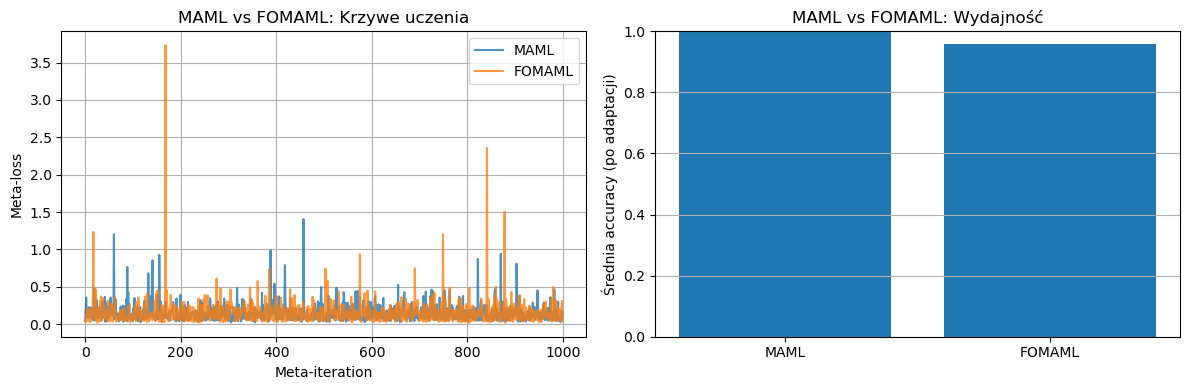

MAML średnia accuracy:   0.997
FOMAML średnia accuracy: 0.960


In [ ]:
# Porównanie MAML vs FOMAML
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, label='MAML', alpha=0.8)
plt.plot(fomaml_losses, label='FOMAML', alpha=0.8)
plt.xlabel('Meta-iteration')
plt.ylabel('Meta-loss')
plt.title('MAML vs FOMAML: Krzywe uczenia')
plt.legend()
plt.grid(True)

# Ewaluacja obu modeli
maml_accs = []
fomaml_accs = []

for _ in range(20):
    sx, sy, qx, qy = generate_task()
    
    _, maml_acc = evaluate_model(model, sx, sy, qx, qy, inner_lr, inner_steps)
    _, fomaml_acc = evaluate_model(fomaml_model, sx, sy, qx, qy, inner_lr, inner_steps)
    
    maml_accs.append(maml_acc)
    fomaml_accs.append(fomaml_acc)

plt.subplot(1, 2, 2)
plt.bar([0, 1], [sum(maml_accs)/len(maml_accs), sum(fomaml_accs)/len(fomaml_accs)])
plt.xticks([0, 1], ['MAML', 'FOMAML'])
plt.ylabel('Średnia accuracy (po adaptacji)')
plt.title('MAML vs FOMAML: Wydajność')
plt.ylim(0, 1)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print(f"MAML średnia accuracy:   {sum(maml_accs)/len(maml_accs):.3f}")
print(f"FOMAML średnia accuracy: {sum(fomaml_accs)/len(fomaml_accs):.3f}")

## Reptile: Najprostsza metoda meta-learningu

### Algorytm Reptile (Nichol et al., 2018)

Reptile jest **znacznie prostszy** niż MAML:

1. Zainicjalizuj parametry $\theta$
2. Dla każdej iteracji:
   - Wylosuj task $T$
   - Skopiuj parametry: $\tilde{\theta} = \theta$
   - Wykonaj $k$ kroków SGD na tasku $T$: $\tilde{\theta} \to \tilde{\theta}'$
   - Meta-update: $\theta \leftarrow \theta + \epsilon(\tilde{\theta}' - \theta)$

### Pseudokod

```
θ = initial_params

for iteration in range(n_iterations):
    task = sample_task()
    θ_copy = copy(θ)
    
    # Zwykły trening na tasku
    for step in range(k_steps):
        loss = compute_loss(θ_copy, task.support)
        θ_copy = θ_copy - α * grad(loss)
    
    # Meta-update: przesuń θ w kierunku θ_copy
    θ = θ + ε * (θ_copy - θ)
```

### Dlaczego to działa?

**Intuicja geometryczna:**
- Każdy task "ciągnie" inicjalizację w swoim kierunku
- Po wielu iteracjach, $\theta$ zbliża się do punktu równowagi
- Ten punkt jest blisko **wszystkich** optymalnych rozwiązań

**Matematyczna interpretacja:**
- Reptile aproksymuje gradient po oczekiwanej wartości tasków
- Działa podobnie do FOMAML, ale jest jeszcze prostszy

### Zalety Reptile

| Cecha | MAML | FOMAML | Reptile |
|-------|------|--------|---------|
| Drugie pochodne | ✅ Tak | ❌ Nie | ❌ Nie |
| Wymaga query set | ✅ Tak | ✅ Tak | ❌ Nie |
| Złożoność implementacji | Wysoka | Średnia | Niska |
| Zużycie pamięci | Wysokie | Średnie | Niskie |

In [ ]:
# Reptile - Implementacja

def reptile_inner_loop(model, support_x, support_y, inner_lr, inner_steps):
    """
    Inner loop dla Reptile - zwykły SGD, zwraca zaadaptowany model.
    """
    # Kopiujemy model
    adapted_model = SimpleClassifier()
    adapted_model.load_state_dict(model.state_dict())
    
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    
    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_x)
        loss = F.cross_entropy(logits, support_y)
        loss.backward()
        optimizer.step()
    
    return adapted_model

# Trening Reptile
reptile_model = SimpleClassifier()
reptile_lr = 0.001  # meta learning rate (epsilon)
inner_lr_reptile = 0.5
inner_steps_reptile = 10  # więcej kroków niż w MAML
n_reptile_iterations = 1000

reptile_losses = []

print("Trening Reptile:")
for meta_iter in range(n_reptile_iterations):
    meta_loss = 0.0
    
    # Wylosuj task (w Reptile nie potrzebujemy query set!)
    support_x, support_y, _, _ = generate_task()
    
    # Inner loop - zwykły SGD
    adapted_model = reptile_inner_loop(
        reptile_model, support_x, support_y, 
        inner_lr_reptile, inner_steps_reptile
    )
    
    # Meta-update: θ = θ + ε(θ' - θ)
    with torch.no_grad():
        for (name, param), (_, adapted_param) in zip(
            reptile_model.named_parameters(), 
            adapted_model.named_parameters()
        ):
            param.data += reptile_lr * (adapted_param.data - param.data)
    
    # Opcjonalnie: śledź loss dla wizualizacji
    if meta_iter % 50 == 0:
        # Sprawdź na nowym tasku
        sx, sy, qx, qy = generate_task()
        adapted = reptile_inner_loop(reptile_model, sx, sy, inner_lr_reptile, 5)
        with torch.no_grad():
            loss = F.cross_entropy(adapted(qx), qy).item()
        reptile_losses.append(loss)
        
        if meta_iter % 200 == 0:
            print(f"  Iteration {meta_iter}, Test loss: {loss:.4f}")

print("Reptile trening zakończony!")

Trening Reptile:
  Iteration 0, Test loss: 0.0324
  Iteration 200, Test loss: 0.0240
  Iteration 400, Test loss: 0.0356
  Iteration 600, Test loss: 0.0244
  Iteration 800, Test loss: 0.6349
Reptile trening zakończony!


In [ ]:
# Ewaluacja Reptile
print("\nEwaluacja Reptile na nowych taskach:")
print("-" * 40)

reptile_accs_before = []
reptile_accs_after = []

for i in range(10):
    support_x, support_y, query_x, query_y = generate_task()
    
    # Przed adaptacją
    with torch.no_grad():
        logits = reptile_model(query_x)
        acc_before = (logits.argmax(1) == query_y).float().mean().item()
    
    # Po adaptacji
    adapted = reptile_inner_loop(reptile_model, support_x, support_y, inner_lr_reptile, 5)
    with torch.no_grad():
        logits = adapted(query_x)
        acc_after = (logits.argmax(1) == query_y).float().mean().item()
    
    reptile_accs_before.append(acc_before)
    reptile_accs_after.append(acc_after)
    print(f"Task {i+1}: Before={acc_before:.2f}, After={acc_after:.2f}")

print("-" * 40)
print(f"Reptile średnia przed adaptacją: {sum(reptile_accs_before)/len(reptile_accs_before):.2f}")
print(f"Reptile średnia po adaptacji:    {sum(reptile_accs_after)/len(reptile_accs_after):.2f}")


Ewaluacja Reptile na nowych taskach:
----------------------------------------
Task 1: Before=0.00, After=1.00
Task 2: Before=0.50, After=0.50
Task 3: Before=0.80, After=1.00
Task 4: Before=0.00, After=1.00
Task 5: Before=0.40, After=0.95
Task 6: Before=0.70, After=0.50
Task 7: Before=0.50, After=1.00
Task 8: Before=0.25, After=1.00
Task 9: Before=0.65, After=1.00
Task 10: Before=0.30, After=1.00
----------------------------------------
Reptile średnia przed adaptacją: 0.41
Reptile średnia po adaptacji:    0.89


## Meta-SGD: Uczenie się learning rate'ów

### Motywacja

W MAML używamy **jednego learning rate** $\alpha$ dla wszystkich parametrów w inner loop. Ale:
- Różne warstwy mogą wymagać różnych prędkości adaptacji
- Niektóre parametry są ważniejsze dla szybkiej adaptacji

### Idea Meta-SGD (Li et al., 2017)

Zamiast uczyć się tylko inicjalizacji $\theta$, uczymy się również **wektora learning rate'ów** $\alpha$:

$$\theta' = \theta - \alpha \odot \nabla_\theta \mathcal{L}(\theta, S)$$

gdzie $\odot$ oznacza mnożenie element-wise, a $\alpha$ ma **taki sam kształt jak $\theta$**.

### Co się uczy?

1. **Inicjalizacja wag** $\theta$ - jak w MAML
2. **Learning rate dla każdego parametru** $\alpha_i$ - nowe!

### Zalety

- Bardziej elastyczna adaptacja
- Automatyczne odkrywanie, które parametry są ważne
- Może działać lepiej niż MAML przy mniejszej liczbie kroków adaptacji

### Pseudokod

```python
# Inicjalizacja
theta = init_weights()
alpha = init_learning_rates()  # np. wszystkie = 0.01

for iteration:
    task = sample_task()
    
    # Inner loop z per-parameter learning rates
    theta_prime = theta - alpha * grad(loss(theta, support))
    
    # Outer loop - aktualizuj ZARÓWNO theta JAK I alpha
    meta_loss = loss(theta_prime, query)
    theta = theta - beta * grad(meta_loss, theta)
    alpha = alpha - beta * grad(meta_loss, alpha)
```

In [ ]:
# Meta-SGD - Implementacja

class MetaSGDClassifier(nn.Module):
    """
    Model z uczącymi się learning rate'ami dla każdego parametru.
    """
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        
        # Learning rates jako parametry - jeden LR per parametr
        # Inicjalizujemy małymi wartościami
        self.lr_fc1_w = nn.Parameter(torch.ones_like(self.fc1.weight) * 0.01)
        self.lr_fc1_b = nn.Parameter(torch.ones_like(self.fc1.bias) * 0.01)
        self.lr_fc2_w = nn.Parameter(torch.ones_like(self.fc2.weight) * 0.01)
        self.lr_fc2_b = nn.Parameter(torch.ones_like(self.fc2.bias) * 0.01)
        self.lr_fc3_w = nn.Parameter(torch.ones_like(self.fc3.weight) * 0.01)
        self.lr_fc3_b = nn.Parameter(torch.ones_like(self.fc3.bias) * 0.01)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def get_params_and_lrs(self):
        """Zwraca pary (parametr, learning_rate)."""
        return [
            (self.fc1.weight, self.lr_fc1_w),
            (self.fc1.bias, self.lr_fc1_b),
            (self.fc2.weight, self.lr_fc2_w),
            (self.fc2.bias, self.lr_fc2_b),
            (self.fc3.weight, self.lr_fc3_w),
            (self.fc3.bias, self.lr_fc3_b),
        ]

def meta_sgd_forward(x, params):
    """Forward pass z podanymi wagami."""
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)
    x = F.linear(x, params[2], params[3])
    x = F.relu(x)
    x = F.linear(x, params[4], params[5])
    return x

def meta_sgd_inner_loop(model, support_x, support_y, inner_steps):
    """
    Inner loop dla Meta-SGD z per-parameter learning rates.
    """
    params_and_lrs = model.get_params_and_lrs()
    
    # Wyciągnij parametry i learning rates
    adapted_params = [p.clone() for p, _ in params_and_lrs]
    learning_rates = [lr for _, lr in params_and_lrs]
    
    for _ in range(inner_steps):
        logits = meta_sgd_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        
        grads = torch.autograd.grad(loss, adapted_params, create_graph=True)
        
        # Aktualizacja z per-parameter learning rates
        adapted_params = [
            p - lr * g 
            for p, lr, g in zip(adapted_params, learning_rates, grads)
        ]
    
    return adapted_params

# Trening Meta-SGD
meta_sgd_model = MetaSGDClassifier()
meta_sgd_optimizer = torch.optim.Adam(meta_sgd_model.parameters(), lr=0.001)

meta_sgd_losses = []
n_meta_sgd_iterations = 1000

print("Trening Meta-SGD:")
for meta_iter in range(n_meta_sgd_iterations):
    meta_loss = 0.0
    
    for _ in range(n_tasks):
        support_x, support_y, query_x, query_y = generate_task()
        
        adapted_params = meta_sgd_inner_loop(meta_sgd_model, support_x, support_y, inner_steps=3)
        
        query_logits = meta_sgd_forward(query_x, adapted_params)
        task_loss = F.cross_entropy(query_logits, query_y)
        
        meta_loss += task_loss
    
    meta_loss = meta_loss / n_tasks
    
    meta_sgd_optimizer.zero_grad()
    meta_loss.backward()
    meta_sgd_optimizer.step()
    
    meta_sgd_losses.append(meta_loss.item())
    
    if meta_iter % 100 == 0:
        print(f"  Iteration {meta_iter}, Loss: {meta_loss.item():.4f}")

print("Meta-SGD trening zakończony!")

Trening Meta-SGD:
  Iteration 0, Loss: 0.6710
  Iteration 100, Loss: 0.2948
  Iteration 200, Loss: 0.1210
  Iteration 300, Loss: 0.0985
  Iteration 400, Loss: 0.1602
  Iteration 500, Loss: 0.0792
  Iteration 600, Loss: 0.0480
  Iteration 700, Loss: 0.1745
  Iteration 800, Loss: 0.0444
  Iteration 900, Loss: 0.0440
Meta-SGD trening zakończony!



Nauczone learning rates w Meta-SGD:
--------------------------------------------------
FC1 weights LR: min=-0.0670, max=0.2466, mean=0.1050
FC2 weights LR: min=-0.1809, max=0.4649, mean=0.1003
FC3 weights LR: min=-0.0521, max=0.4281, mean=0.1490


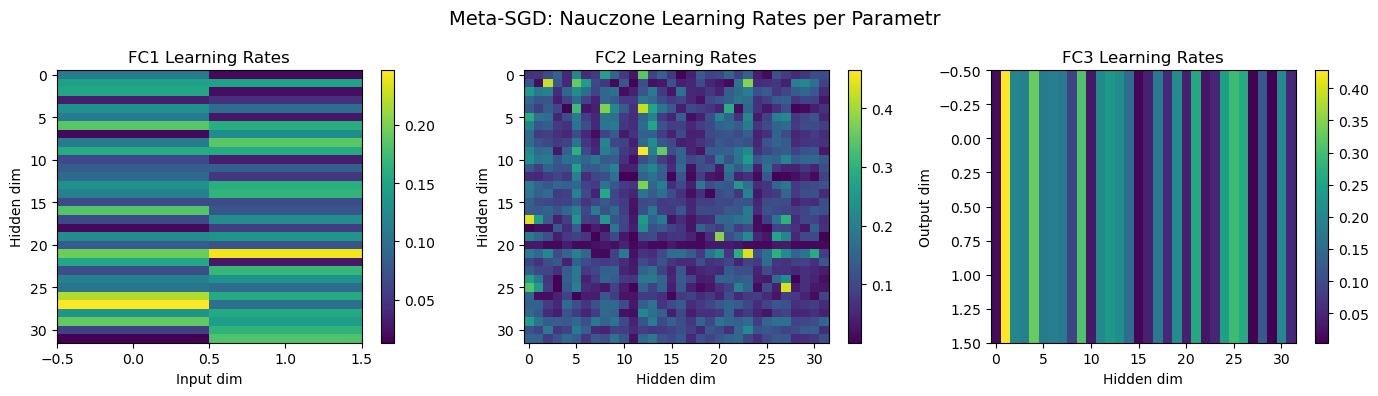

In [ ]:
# Wizualizacja nauczonych learning rate'ów
print("\nNauczone learning rates w Meta-SGD:")
print("-" * 50)

with torch.no_grad():
    print(f"FC1 weights LR: min={meta_sgd_model.lr_fc1_w.min():.4f}, "
          f"max={meta_sgd_model.lr_fc1_w.max():.4f}, "
          f"mean={meta_sgd_model.lr_fc1_w.mean():.4f}")
    print(f"FC2 weights LR: min={meta_sgd_model.lr_fc2_w.min():.4f}, "
          f"max={meta_sgd_model.lr_fc2_w.max():.4f}, "
          f"mean={meta_sgd_model.lr_fc2_w.mean():.4f}")
    print(f"FC3 weights LR: min={meta_sgd_model.lr_fc3_w.min():.4f}, "
          f"max={meta_sgd_model.lr_fc3_w.max():.4f}, "
          f"mean={meta_sgd_model.lr_fc3_w.mean():.4f}")

# Wizualizacja - z obsługą błędów numpy
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

def tensor_to_array(t):
    """Konwertuje tensor do formatu akceptowanego przez imshow."""
    try:
        return t.cpu().detach().numpy()
    except RuntimeError:
        # Fallback gdy numpy nie jest dostępne
        return t.cpu().detach().tolist()

with torch.no_grad():
    lr1 = tensor_to_array(meta_sgd_model.lr_fc1_w.abs())
    lr2 = tensor_to_array(meta_sgd_model.lr_fc2_w.abs())
    lr3 = tensor_to_array(meta_sgd_model.lr_fc3_w.abs())
    
    im1 = axes[0].imshow(lr1, aspect='auto', cmap='viridis')
    axes[0].set_title('FC1 Learning Rates')
    axes[0].set_xlabel('Input dim')
    axes[0].set_ylabel('Hidden dim')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(lr2, aspect='auto', cmap='viridis')
    axes[1].set_title('FC2 Learning Rates')
    axes[1].set_xlabel('Hidden dim')
    axes[1].set_ylabel('Hidden dim')
    plt.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(lr3, aspect='auto', cmap='viridis')
    axes[2].set_title('FC3 Learning Rates')
    axes[2].set_xlabel('Hidden dim')
    axes[2].set_ylabel('Output dim')
    plt.colorbar(im3, ax=axes[2])

plt.suptitle('Meta-SGD: Nauczone Learning Rates per Parametr', fontsize=14)
plt.tight_layout()
plt.show()

## Porównanie wszystkich metod Meta-Learning

Teraz porównajmy wszystkie zaimplementowane metody:

| Metoda | Opis | Złożoność | Pamięć |
|--------|------|-----------|--------|
| **MAML** | Pełne drugie pochodne | Wysoka | Wysoka |
| **FOMAML** | Ignoruje drugie pochodne | Średnia | Średnia |
| **Reptile** | Przesuwanie w kierunku rozwiązań | Niska | Niska |
| **Meta-SGD** | MAML + uczenie learning rates | Wysoka | Wysoka |

### Kiedy używać której metody?

- **MAML**: Gdy masz zasoby i potrzebujesz najlepszej wydajności
- **FOMAML**: Dobry kompromis między wydajnością a szybkością
- **Reptile**: Gdy prostota jest kluczowa, lub gdy nie masz query set
- **Meta-SGD**: Gdy różne parametry wymagają różnych prędkości adaptacji

In [ ]:
# Wielkie porównanie wszystkich metod

def evaluate_method(model, forward_fn, adaptation_fn, n_tasks=20):
    """Uniwersalna funkcja ewaluacji."""
    accs_before = []
    accs_after = []
    
    for _ in range(n_tasks):
        sx, sy, qx, qy = generate_task()
        
        # Przed adaptacją
        with torch.no_grad():
            if forward_fn is None:
                logits = model(qx)
            else:
                params = [p.clone() for p in model.parameters() if p.requires_grad][:6]
                logits = forward_fn(qx, params)
            acc_before = (logits.argmax(1) == qy).float().mean().item()
        
        # Po adaptacji
        acc_after = adaptation_fn(model, sx, sy, qx, qy)
        
        accs_before.append(acc_before)
        accs_after.append(acc_after)
    
    return accs_before, accs_after

# Funkcje adaptacji dla każdej metody
def adapt_maml(model, sx, sy, qx, qy):
    params = {k: v.clone() for k, v in model.named_parameters()}
    adapted = inner_loop_update(params, sx, sy, inner_lr, inner_steps)
    with torch.no_grad():
        logits = functional_forward(qx, adapted)
        return (logits.argmax(1) == qy).float().mean().item()

def adapt_reptile(model, sx, sy, qx, qy):
    adapted = reptile_inner_loop(model, sx, sy, 0.5, 5)
    with torch.no_grad():
        logits = adapted(qx)
        return (logits.argmax(1) == qy).float().mean().item()

def adapt_meta_sgd(model, sx, sy, qx, qy):
    adapted_params = meta_sgd_inner_loop(model, sx, sy, 3)
    with torch.no_grad():
        logits = meta_sgd_forward(qx, adapted_params)
        return (logits.argmax(1) == qy).float().mean().item()

# Ewaluacja
print("Porównanie metod Meta-Learning (20 tasków):")
print("=" * 60)

results = {}

# MAML
maml_before, maml_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    b, a = evaluate_model(model, sx, sy, qx, qy, inner_lr, inner_steps)
    maml_before.append(b)
    maml_after.append(a)
results['MAML'] = (maml_before, maml_after)

# FOMAML
fomaml_before, fomaml_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    b, a = evaluate_model(fomaml_model, sx, sy, qx, qy, inner_lr, inner_steps)
    fomaml_before.append(b)
    fomaml_after.append(a)
results['FOMAML'] = (fomaml_before, fomaml_after)

# Reptile
reptile_before, reptile_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    with torch.no_grad():
        b = (reptile_model(qx).argmax(1) == qy).float().mean().item()
    a = adapt_reptile(reptile_model, sx, sy, qx, qy)
    reptile_before.append(b)
    reptile_after.append(a)
results['Reptile'] = (reptile_before, reptile_after)

# Meta-SGD
meta_sgd_before, meta_sgd_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    with torch.no_grad():
        b = (meta_sgd_model(qx).argmax(1) == qy).float().mean().item()
    a = adapt_meta_sgd(meta_sgd_model, sx, sy, qx, qy)
    meta_sgd_before.append(b)
    meta_sgd_after.append(a)
results['Meta-SGD'] = (meta_sgd_before, meta_sgd_after)

# Wyświetl wyniki
for name, (before, after) in results.items():
    print(f"{name:12s}: Before={sum(before)/len(before):.3f}, "
          f"After={sum(after)/len(after):.3f}, "
          f"Gain={sum(after)/len(after) - sum(before)/len(before):+.3f}")

Porównanie metod Meta-Learning (20 tasków):
MAML        : Before=0.530, After=0.953, Gain=+0.423
FOMAML      : Before=0.540, After=0.933, Gain=+0.393
Reptile     : Before=0.550, After=0.957, Gain=+0.407
Meta-SGD    : Before=0.500, After=0.995, Gain=+0.495


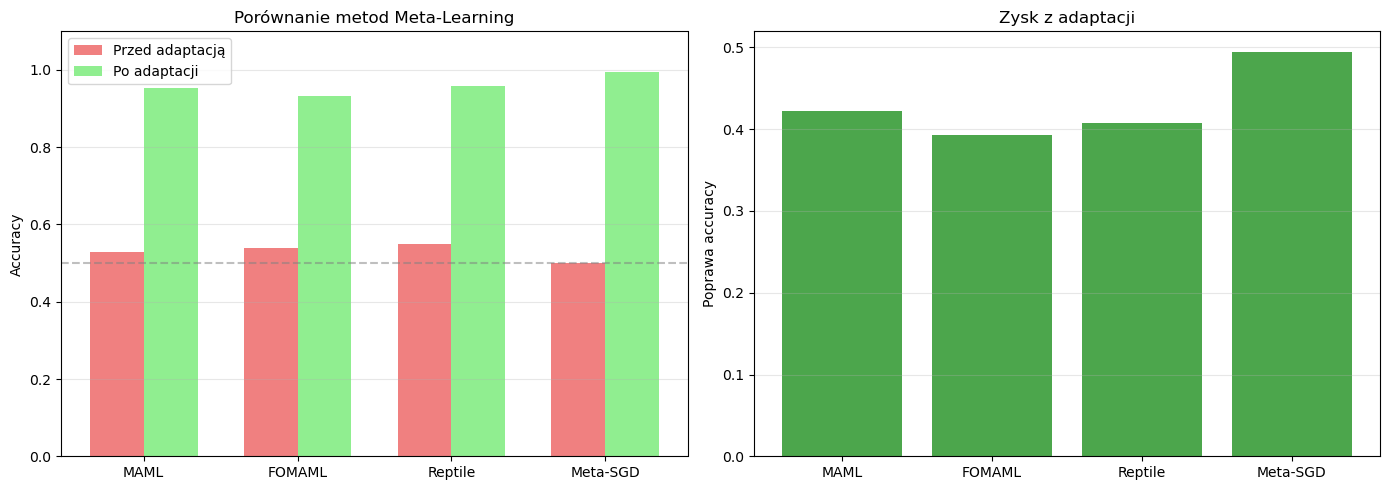


Wnioski:
- Wszystkie metody skutecznie adaptują się do nowych tasków
- MAML i Meta-SGD dają najlepsze wyniki (drugie pochodne)
- FOMAML jest dobrym kompromisem
- Reptile jest najprostszy, ale też skuteczny


In [ ]:
# Wizualizacja porównawcza
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Accuracy przed i po adaptacji
methods = list(results.keys())
before_means = [sum(results[m][0])/len(results[m][0]) for m in methods]
after_means = [sum(results[m][1])/len(results[m][1]) for m in methods]

x = range(len(methods))
width = 0.35

bars1 = axes[0].bar([i - width/2 for i in x], before_means, width, label='Przed adaptacją', color='lightcoral')
bars2 = axes[0].bar([i + width/2 for i in x], after_means, width, label='Po adaptacji', color='lightgreen')

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Porównanie metod Meta-Learning')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
axes[0].grid(True, axis='y', alpha=0.3)

# Wykres 2: Gain (poprawa po adaptacji)
gains = [after_means[i] - before_means[i] for i in range(len(methods))]
colors = ['green' if g > 0 else 'red' for g in gains]
axes[1].bar(methods, gains, color=colors, alpha=0.7)
axes[1].set_ylabel('Poprawa accuracy')
axes[1].set_title('Zysk z adaptacji')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nWnioski:")
print("- Wszystkie metody skutecznie adaptują się do nowych tasków")
print("- MAML i Meta-SGD dają najlepsze wyniki (drugie pochodne)")
print("- FOMAML jest dobrym kompromisem")
print("- Reptile jest najprostszy, ale też skuteczny")

## Zaawansowane aspekty Meta-Learningu

### 1. Task Distribution

Wydajność meta-learningu silnie zależy od **dystrybucji tasków** podczas treningu:
- Taski treningowe powinny być podobne do tasków testowych
- Zbyt łatwe taski = model się nie uczy
- Zbyt trudne taski = model się nie uczy
- Optymalna trudność = taski, które są rozwiązywalne po adaptacji

### 2. Liczba kroków adaptacji

| Mało kroków (1-3) | Dużo kroków (10+) |
|-------------------|-------------------|
| Szybsza adaptacja | Lepsza wydajność |
| Mniej overfittingu | Ryzyko overfittingu na support set |
| Wymaga lepszej inicjalizacji | Bardziej elastyczne |

### 3. Stabilność treningu

MAML może być niestabilny z powodu:
- Eksplodujących gradientów (drugie pochodne)
- Zbyt dużych learning rate'ów

Rozwiązania:
- Gradient clipping
- Mniejsze learning rate'y
- FOMAML zamiast pełnego MAML

### 4. Skalowanie do większych modeli

Dla dużych modeli (ResNet, Transformers):
- MAML jest bardzo kosztowny pamięciowo
- FOMAML lub Reptile są praktyczniejsze
- Można też adaptować tylko część warstw (np. ostatnie)

### 5. Meta-Learning w innych domenach

Meta-learning nie ogranicza się do klasyfikacji obrazów:
- **Reinforcement Learning**: Szybka adaptacja do nowych zadań
- **NLP**: Few-shot learning dla nowych języków/zadań
- **Drug Discovery**: Uczenie z małej liczby próbek
- **Robotics**: Adaptacja do nowych środowisk

## Porównanie: Metric-Based vs Meta-Learning

| Aspekt | Prototypical Networks | MAML |
|--------|----------------------|------|
| **Co się uczy?** | Embedding space | Inicjalizacja wag |
| **Adaptacja wag podczas inference?** | ❌ Nie | ✅ Tak |
| **Złożoność obliczeniowa** | Niska | Wysoka (gradienty przez gradienty) |
| **Elastyczność** | Tylko klasyfikacja z metryką | Dowolne zadanie (regresja, RL, etc.) |
| **Wymagania pamięci** | Niskie | Wysokie |
| **Łatwość implementacji** | Prosta | Trudniejsza |
| **Kiedy lepsze?** | Dobre embeddingi, proste zadania | Trudne adaptacje, różnorodne zadania |

### Kiedy używać czego?

**Metric-based (ProtoNet, MatchingNet):**
- Masz dobry pretrenowany encoder
- Zadania są podobne do tych z pretrainingu
- Potrzebujesz szybkiej inference

**Meta-learning (MAML):**
- Zadania wymagają prawdziwej adaptacji
- Różnorodne typy zadań
- Masz zasoby obliczeniowe

---

# Ćwiczenia

## Ćwiczenie 2 (Obowiązkowe): Implementacja MAML Inner Loop

**Zadanie:** Uzupełnij poniższy kod, implementując pętlę wewnętrzną (inner loop) MAML.

Musisz:
1. **TODO 1:** Wykonać forward pass z aktualnymi wagami
2. **TODO 2:** Obliczyć gradienty i zaktualizować wagi
3. **TODO 3:** Obliczyć loss na query set po adaptacji
4. **TODO 4:** Obliczyć accuracy przed i po adaptacji

In [ ]:
# Ćwiczenie 2: Implementacja MAML Inner Loop
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

# Model
class TinyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Funkcja generująca task
def create_task():
    angle = torch.rand(1) * 2 * 3.14159
    direction = torch.tensor([torch.cos(angle), torch.sin(angle)]).squeeze()
    offset = torch.randn(2) * 2
    c0, c1 = offset - direction * 2, offset + direction * 2
    
    sx = torch.cat([torch.randn(5, 2) * 0.5 + c0, torch.randn(5, 2) * 0.5 + c1])
    sy = torch.cat([torch.zeros(5), torch.ones(5)]).long()
    qx = torch.cat([torch.randn(10, 2) * 0.5 + c0, torch.randn(10, 2) * 0.5 + c1])
    qy = torch.cat([torch.zeros(10), torch.ones(10)]).long()
    
    return sx, sy, qx, qy

# Forward funkcjonalny
def tiny_forward(x, params):
    x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
    return x

# Parametry
inner_lr = 0.5
inner_steps = 5

# Inicjalizacja modelu
exercise_model = TinyClassifier()

# Generuj task
support_x, support_y, query_x, query_y = create_task()

# Pobierz parametry
params = {k: v.clone() for k, v in exercise_model.named_parameters()}

# --------------------------
# Accuracy PRZED adaptacją
# --------------------------
with torch.no_grad():
    logits_before = tiny_forward(query_x, params)
    preds_before = logits_before.argmax(dim=1)
    acc_before = (preds_before == query_y).float().mean().item()
    print(f"Accuracy PRZED adaptacją: {acc_before:.2f}")

# --------------------------
# TODO: Inner loop - adaptacja na support set
# Wykonaj `inner_steps` kroków gradient descent
# --------------------------
adapted_params = {k: v.clone() for k, v in params.items()}

for step in range(inner_steps):
    # TODO 1: Forward pass z adapted_params
    logits = None  # <-- UZUPEŁNIJ
    
    # TODO 2: Oblicz loss i gradienty, zaktualizuj adapted_params
    loss = None  # <-- UZUPEŁNIJ
    grads = None  # <-- UZUPEŁNIJ (użyj torch.autograd.grad)
    
    # Aktualizacja wag (odkomentuj po uzupełnieniu powyższego)
    # adapted_params = {
    #     k: v - inner_lr * g 
    #     for (k, v), g in zip(adapted_params.items(), grads)
    # }

# --------------------------
# TODO 3: Oblicz accuracy PO adaptacji
# --------------------------
with torch.no_grad():
    logits_after = None  # <-- UZUPEŁNIJ
    preds_after = None   # <-- UZUPEŁNIJ
    acc_after = None     # <-- UZUPEŁNIJ

# Odkomentuj po uzupełnieniu:
# print(f"Accuracy PO adaptacji: {acc_after:.2f}")
# print(f"Poprawa: {acc_after - acc_before:+.2f}")

## Ćwiczenie 3 (Opcjonalne): Porównanie liczby kroków adaptacji

**Zadanie:** Zbadaj wpływ liczby kroków adaptacji (`inner_steps`) na wydajność MAML.

Musisz:
1. Przetestować różne wartości `inner_steps`: [1, 3, 5, 10, 20]
2. Dla każdej wartości obliczyć średnią accuracy na 20 taskach
3. Narysować wykres pokazujący zależność accuracy od liczby kroków
4. Wyciągnąć wnioski

In [ ]:
# Ćwiczenie 3: Porównanie liczby kroków adaptacji

# Lista wartości inner_steps do przetestowania
steps_to_test = [1, 3, 5, 10, 20]
n_test_tasks = 20

# TODO: Uzupełnij poniższy kod

results_by_steps = {}

for n_steps in steps_to_test:
    accs = []
    
    for _ in range(n_test_tasks):
        sx, sy, qx, qy = generate_task()
        
        # TODO: Użyj funkcji evaluate_model z odpowiednim n_steps
        # Wskazówka: evaluate_model(model, sx, sy, qx, qy, inner_lr, n_steps)
        _, acc = None, None  # <-- UZUPEŁNIJ
        
        # accs.append(acc)
    
    # results_by_steps[n_steps] = sum(accs) / len(accs)
    # print(f"inner_steps={n_steps:2d}: accuracy={results_by_steps[n_steps]:.3f}")

# TODO: Narysuj wykres
# plt.figure(figsize=(10, 5))
# plt.plot(list(results_by_steps.keys()), list(results_by_steps.values()), 'o-', linewidth=2, markersize=8)
# plt.xlabel('Liczba kroków adaptacji (inner_steps)')
# plt.ylabel('Średnia accuracy')
# plt.title('Wpływ liczby kroków adaptacji na wydajność MAML')
# plt.grid(True)
# plt.show()

# TODO: Napisz wnioski w komentarzu poniżej
# Wnioski:
# 1. ...
# 2. ...
# 3. ...